# Step B - Multiple Instance Detection

- Freddy

In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
sift = cv2.SIFT_create()

In [42]:
def FeatureMatch(Model_Descriptors, Scene_Descriptors, Treshold = 0.45, k=2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    # Create FLANN-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(Model_Descriptors, Scene_Descriptors, k)
    # Filter out good matches using Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < Treshold * n.distance:
            good.append(m)
    return good

In [43]:
def findmodel(x, check):
    # Return model number and label based on model index x
    model_map = {
        0: "Nesquik", 1: "CK blue", 11: "CK orange",
        19: "Country crisp", 24: "Fitness", 25: "CocoPops", 26: "Nesquik Duo"
    }
    return x, model_map.get(x, "Unknown")

def Output(detections, sce_id):
    # Print the detection results for each model in a given scene
    for x in models:
        model_number, model_label = findmodel(x, check=False)
        print(f'Product {model_label} (Model {model_number}) - {detections[sce_id][x]["count"]} instance/s found:')
        # Print details for each detected instance
        for index, width in enumerate(detections[sce_id][x].get('width', [])):
            pos = detections[sce_id][x]['pos'][index] if index < len(detections[sce_id][x]['pos']) else "N/A"
            print(f'\tInstance {index + 1} position: {pos}, width: {width}px, height: {detections[sce_id][x]["height"][index]}px')
    print('_' * 50 + '\n')


In [44]:
# Calculate euclidean distance between two points A and B
def Eucdist(A, B):
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

In [45]:
def draw_bbox(img, bbox, scene_images, s):
    # Draw bounding boxes on the image
    if img is None:
        img = np.copy(scene_images[s][IMAGE_INDEX])
    for top_L, bot_R in bbox:
        img = cv2.rectangle(img, top_L, bot_R, (0, 255, 0), 15)
    return img if bbox else None

In [46]:
def adjust_bbox(bbox, scene_image):
    # Adjust bounding box coordinates to fit within the scene image boundaries
    adjusted_bbox = []
    scene_height, scene_width = scene_image[s][IMAGE_INDEX].shape[:2]

    for top_left, bottom_right in bbox:
        top_left = (max(min(int(top_left[0]), scene_width), 0), max(min(int(top_left[1]), scene_height), 0))
        bottom_right = (max(min(int(bottom_right[0]), scene_width), 0), max(min(int(bottom_right[1]), scene_height), 0))
        adjusted_bbox.append([top_left, bottom_right])
    return adjusted_bbox

In [47]:
# Function to divide an image into bins and calculate the mean color in each bin
def bins(image, bins_w=3, bins_h=4):
    bins = {}
    img_width, img_height = image.shape[1], image.shape[0]
    step_width, step_height = img_width // bins_w, img_height // bins_h

    for r in range(bins_h):
        for c in range(bins_w):
            # Calculate the coordinates for each bin
            start_row, end_row = r * step_height, min((r + 1) * step_height, img_height)
            start_col, end_col = c * step_width, min((c + 1) * step_width, img_width)
            # Extract and compute the mean color of each bin
            bin_img = image[start_row:end_row, start_col:end_col]
            mean_colors = tuple(np.mean(bin_img[:, :, x]) for x in range(3))  # For each channel: B, G, R
            bins[r, c] = mean_colors
    return bins

In [48]:
# Function to bounding boxes based on color binning and thresholding
def color_bins(adjusted_bbox, 
               scene_image, m, s, N=3, M=4, 
               threshold=80, bad_threshold=1):

    main_bbox = []
    bins_mod = bins(model_features[m][IMAGE_INDEX], N, M)

    # Check each bounding box in the adjusted list
    for [top_left, bottom_right] in adjusted_bbox:
        scene_bins = bins(scene_image[s][IMAGE_INDEX][top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]], N, M)

    # Count bins that differ significantly from the model image
        bad = sum(
            1 for k, v in bins_mod.items() 
            if any(np.absolute(v[x] - scene_bins[k][x]) >= threshold for x in range(3))
)
    
    # If the number of significantly different bins is below the threshold, include the bounding box
        if bad < bad_threshold:
            main_bbox.append([
                (int(top_left[0]), int(top_left[1])),
                (int(bottom_right[0]), int(bottom_right[1]))
            ])
    return main_bbox

In [49]:
def display_model_images(model_features):
    # Display images of all models with labels
    fig = plt.figure(figsize=(15, 10))
    for x, (model_id, features) in enumerate(model_features.items()):
        img_rgb = cv2.cvtColor(features[0], cv2.COLOR_BGR2RGB)
        _, model_label = findmodel(model_id, check=False)
        plt.subplot(2, (len(model_features) + 1) // 2, x + 1)
        plt.title(f"Model {model_id}: {model_label}")
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

In [50]:
def Center(model_img, model_features, x, CENTER_INDEX=3):
    # Compute the center of the model image and update model features
    center = (model_img.shape[1] // 2, model_img.shape[0] // 2)
    if len(model_features[x]) <= CENTER_INDEX:
        model_features[x].append(center)
    else:
        model_features[x][CENTER_INDEX] = center
    return center

In [51]:
def ComputeVoteVector(Good_Matches, model_features, x):
    # Compute voting vectors based on good matches and model features
    G_x, G_y = model_features[x][CENTER_INDEX]  # Center of the model image
    V = []  # List to store voting vectors
    for m in Good_Matches:
        # Get coordinates of the matched keypoint in the model image
        Kp_x, Kp_y = [int(coord) for coord in model_features[x][KEYPOINT_INDEX][m.queryIdx].pt]
        # Calculate the voting vector from the center to the keypoint
        vx, vy = Kp_x - G_x, Kp_y - G_y
        # Determine the slope of the vector
        slope = [vx / vy, 1] if vy != 0 else ([1, 0] if vy == 0 else [0, 0])
        V.append([vx, vy, slope])  # Add the vector and slope to the list
    # Update the model features with the computed voting vectors
    if len(model_features[x]) <= V_INDEX:
        model_features[x].append(V)
    else:
        model_features[x][V_INDEX] = V
    return V

In [52]:
def Comp_Kp(model_feat, scene_feat, Good_Matches):
    # Compare keypoints between model and scene images
    kp_mod_size, kp_scene_size, kp_mod_angle, kp_scene_angle = [], [], [], []

    for o in Good_Matches:
        # Retrieve the matched keypoints from model and scene
        M_kp, S_kp = model_feat[x][KEYPOINT_INDEX][o.queryIdx], scene_feat[s][KEYPOINT_INDEX][o.trainIdx]
        # Append size and angle to respective lists
        kp_mod_size.append(M_kp.size)
        kp_scene_size.append(S_kp.size)
        kp_mod_angle.append(M_kp.angle)
        kp_scene_angle.append(S_kp.angle)

    # Calculate ratios and relative angles
    size_ratio = [m / s if s != 0 else 0 for m, s in zip(kp_mod_size, kp_scene_size)]
    angle_diff = [m - s for m, s in zip(kp_mod_angle, kp_scene_angle)]

    # Compute mean values for scale factor and relative angle
    mean_size = np.mean(size_ratio) if size_ratio else 3.5
    mean_angle = np.mean(angle_diff) if angle_diff else 0
    return mean_size, mean_angle

In [53]:
def Accumulator_ar(accumalator_1, accumalator_2, Scene_img, Model_img, 
                   model_feat, scene_feat, Good_Matches, V, x, s, KEYPOINT_INDEX=1):
    # Calculate the dimensions for the accumulator array based on scene image size and accumulator parameters
    scene_height, scene_width = scene_feat[s][0].shape[:2]
    Acc_dim = (int(scene_height / accumalator_2), int(scene_width / accumalator_1))
    Accumulator_ar = np.zeros(Acc_dim)  # Initialize accumulator array
    Accumulator_ar_pts = {}  # Dictionary to store accumulator points

    # Get matched scene keypoints coordinates
    scene_pts = np.float32([scene_feat[s][KEYPOINT_INDEX][match.trainIdx].pt for match in Good_Matches]).reshape(-1, 1, 2)
    r, alpha = Comp_Kp(model_feat, scene_feat, Good_Matches)  # Compute scale factor and relative angle

    G_scene = []  # Initialize list to store center estimations
    for l, (vx, vy, _) in enumerate(V):
        # Calculate the rescaled voting vector
        Vx_scene, Vy_scene = vx / r, vy / r
        # Estimate center position
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene
        G_scene.append([Gx_scene, Gy_scene])  # Add center estimation to list
        # Calculate indices in the accumulator array
        GS_x, GS_y = int(Gx_scene / accumalator_1), int(Gy_scene / accumalator_2)

        # Update the accumulator array if indices are within bounds
        if 0 <= GS_x < Acc_dim[1] and 0 <= GS_y < Acc_dim[0]:
            Accumulator_ar[GS_y, GS_x] += 1
            cell_key = (GS_y, GS_x, 'S')
            Accumulator_ar_pts.setdefault(cell_key, []).append((Gx_scene, Gy_scene))

    return Accumulator_ar, G_scene, Accumulator_ar_pts

In [54]:
def center_estimation(model_feat, scene_feat, Good_Matches, V, s):
    # Get matched scene keypoints coordinates
    scene_pts = np.float32([scene_feat[s][KEYPOINT_INDEX][m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    r, alpha = Comp_Kp(model_feat, scene_feat, Good_Matches)  # Compute scale factor and relative angle

    G_scene = []  # Initialize list to store center estimations
    for l in range(len(Good_Matches)):
        # Rescale voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        # Estimate center position
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene
        # Add center estimation to list
        G_scene.append([Gx_scene, Gy_scene])
    return G_scene, r

In [55]:
# Function to merge overlapping bounding boxes based on a distance threshold
def overlap_bbox(bbox_corners, dist_thres=200):
    bbox = []  # Initialize an empty list to store final bounding boxes

    # Iterate over each bounding box
    for current_box in bbox_corners:
        top_L, bot_R = current_box  # Get top left and bottom right corners of the current box
        merged = False  # Flag to check if current box is merged with an existing box

        # Check if the current box overlaps with any existing box
        for x, (top_left, bottom_right) in enumerate(bbox):
            # If the boxes are close enough based on Euclidean distance, merge them
            if (Eucdist(top_L, top_left) < dist_thres and Eucdist(bot_R, bottom_right) < dist_thres):
                # Calculate the mean of the corners to merge the boxes
                mean_tl = tuple(map(lambda x, y: int((x + y) / 2), top_L, top_left))
                mean_br = tuple(map(lambda x, y: int((x + y) / 2), bot_R, bottom_right))
                bbox[x] = [mean_tl, mean_br]  # Update the bounding box with merged coordinates
                merged = True  # Set the flag as merged
                break

        # If the box is not merged, add it as a new box
        if not merged:
            bbox.append([top_L, bot_R])

    return bbox  # Return the list of merged/non-overlapping bounding boxes


In [56]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
TRESHOLD_INDEX = 5
accumalator_1 = 120
accumalator_2 = 120
MIN_VOTES = 1

detections = {}
scenes_bbox = {}
# Dictionary that contains the image, all keypoints and descriptors for each model images
model_features = {}
scenes_features = {}
model_means = {}

models = [0, 1, 11, 19, 24, 25, 26]
scenes = [1,2,3,4,5]

# Process each model image
for x in models:
    model_img = cv2.imread('./models/{}.jpg'.format(x), cv2.COLOR_BGR2RGB)
    mod_keypoint = sift.detect(model_img)
    mod_keypoint, mod_des = sift.compute(model_img, mod_keypoint)
    model_features[x] = [model_img, mod_keypoint, mod_des]
    # Calculate and store mean color values
    b,g,r = cv2.split(model_features[x][IMAGE_INDEX])
    model_means[x] = [np.mean(r), np.mean(g), np.mean(b)]
    # Compute and store center of the model image
    Center(model_img,model_features, x, CENTER_INDEX=3) 

# Process each scene image
for x in scenes:
    scene_img = cv2.imread('./scenes/m{}.png'.format(x), cv2.COLOR_BGR2RGB)
    scene_keypoint = sift.detect(scene_img)
    scene_keypoint, scene_des = sift.compute(scene_img, scene_keypoint)
    scenes_features[x] = [scene_img, scene_keypoint, scene_des]

In [57]:
for s in scenes:
    # Copying the scene image for bounding box drawing
    scenes_bbox[s] = np.copy(scenes_features[s][IMAGE_INDEX])
    detections[s] = {}
    for x in models:
        # Reading scene and model images for each model-scene pair
        scene_img = cv2.imread('./scenes/m{}.png'.format(s), cv2.COLOR_BGR2RGB)
        model_img = cv2.imread('./models/{}.jpg'.format(x), cv2.COLOR_BGR2RGB)
        detections[s][x] = {}
        detections[s][x]['count'] = 0
        
        for _ in range(2):
            # Finding matches between scene keypoints and model keypoints
            matches = FeatureMatch(model_features[x][DESCRIPTOR_INDEX], scenes_features[s][DESCRIPTOR_INDEX])

        # Computing vote vectors based on good matches            
        V = ComputeVoteVector(matches,model_features, x)
        
        # Generating an accumulator array for voting, along with scene keypoints and other details
        ACC, G_scene, Accumulator_ar_pts = Accumulator_ar(accumalator_1, accumalator_2, scene_img, model_img, model_features, scenes_features, matches, V, x, s)
        for g in G_scene :
            cv2.circle(scene_img,(int(g[0]), int(g[1])), 10, (255,55,236),25)
        model_scene_current = []
        
        # Iterating through the accumulator array to find significant votes
        for t in range(ACC.shape[0]):
            for w in range(ACC.shape[1]):
                if ACC[t,w] >= MIN_VOTES:
                    model_scene_current.append([t, w])
        
        # Estimating the center of the model in the scene
        G_scenes, r = center_estimation(model_features, scenes_features, matches, V, s)

        model_h = model_features[x][IMAGE_INDEX].shape[0] / r                                               
        model_w = model_features[x][IMAGE_INDEX].shape[1] / r

        #cereal box shape
        if model_w < model_h:
            image1 = np.copy(scenes_features[s][IMAGE_INDEX])
            bbox_corners = []
            for c in model_scene_current :
                
                # Calculating the height and width of the model based on scaling ratio
                G_mean = np.mean(Accumulator_ar_pts[(c[0], c[1], 'S')], axis=0)
                cv2.circle(scene_img,(int(G_mean[0]), int(G_mean[1])), 20, (0,0,0),25)
                cv2.rectangle(scene_img,(c[1]*accumalator_1,c[0]*accumalator_2),
                              ((c[1]+1)*accumalator_1,(c[0]+1)*accumalator_2),(0,255,0),10)
                tl_bbox = ( int(int(G_mean[0]) - (model_w / 2) ), 
                                                int(int(G_mean[1]) - (model_h / 2) ) )
                br_bbox = ( int(int(G_mean[0]) + (model_w / 2) ), 
                                                int(int(G_mean[1]) + (model_h / 2) ) )
                bbox_corners.append([tl_bbox, br_bbox]) 
                scene_img_with_bounding_boxes = cv2.rectangle(image1,
                                              tl_bbox,
                                              br_bbox,
                                              (0,255,0), 10)
            
            # Adjusting and filtering bounding boxes
            adjusted_bbox = adjust_bbox(bbox_corners, scenes_features)
            main_bbox = color_bins(adjusted_bbox, scenes_features, x, s)
            
            bbox = overlap_bbox(main_bbox)
            scene_img_sctioned = np.copy(scene_img)
            m_img_bb = draw_bbox(scenes_bbox[s], bbox, scenes_features, s)

            if m_img_bb is not None:
                scenes_bbox[s] = m_img_bb
            
            # Updating detection info for each model
            detections[s][x]['count'] += len(bbox)
            detections[s][x]['width'] = []
            detections[s][x]['height'] = []
            detections[s][x]['pos'] = []
            
            for index_1, [top_L, bot_R] in enumerate(bbox):
                top_R = (bot_R[0], top_L[1])
                bbox_w = Eucdist(top_L, top_R)
                bbox_h = Eucdist(top_R, bot_R)
                detections[s][x]['width'].append(bbox_w)
                detections[s][x]['height'].append(bbox_h)
                center_x = int((top_L[0] + bot_R[0]) / 2)
                center_y = int((top_L[1] + bot_R[1]) / 2)
                detections[s][x]['pos'].append((center_x, center_y))

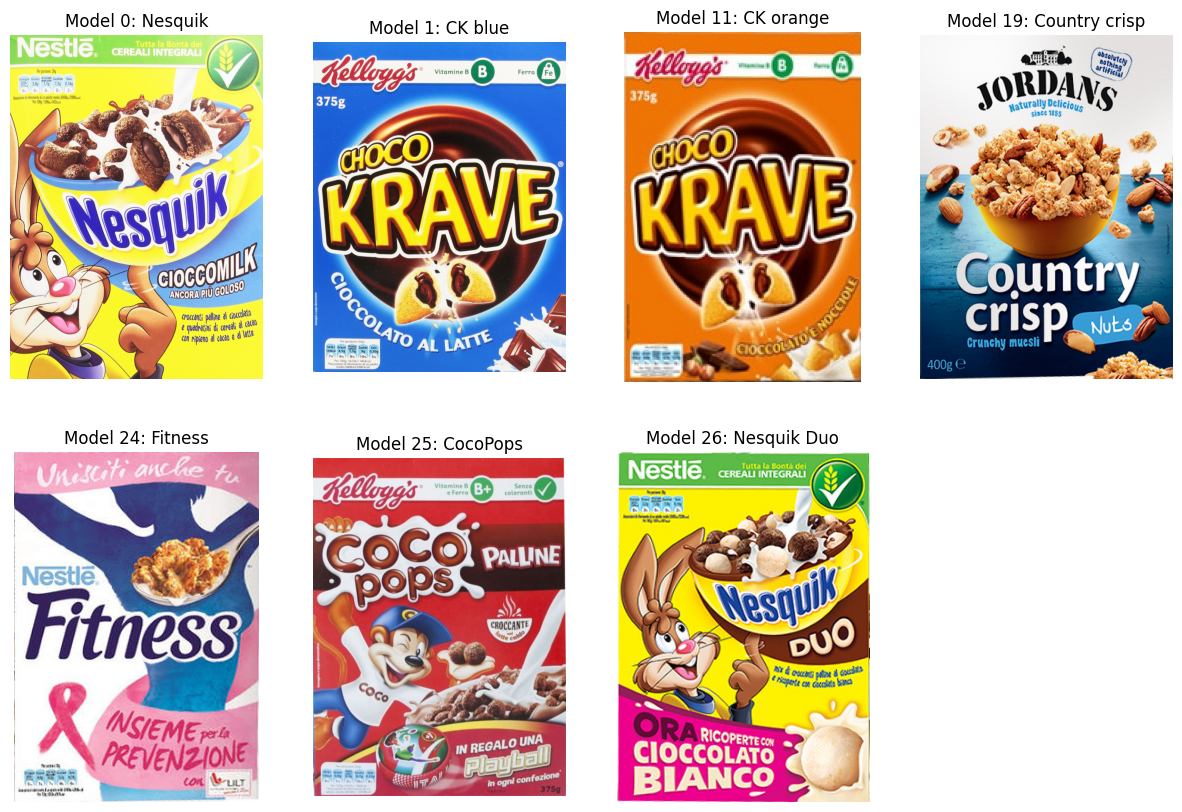

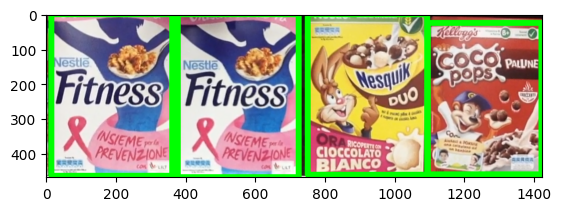

Product Nesquik (Model 0) - 0 instance/s found:
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 0 instance/s found:
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 2 instance/s found:
	Instance 1 position: (188, 231), width: 347.0px, height: 463.0px
	Instance 2 position: (551, 233), width: 347.0px, height: 467.0px
Product CocoPops (Model 25) - 1 instance/s found:
	Instance 1 position: (1259, 242), width: 326.0px, height: 434.0px
Product Nesquik Duo (Model 26) - 1 instance/s found:
	Instance 1 position: (922, 230), width: 343.0px, height: 460.0px
__________________________________________________



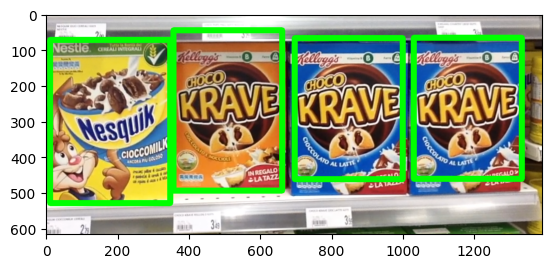

Product Nesquik (Model 0) - 1 instance/s found:
	Instance 1 position: (179, 300), width: 337.0px, height: 457.0px
Product CK blue (Model 1) - 2 instance/s found:
	Instance 1 position: (848, 264), width: 303.0px, height: 395.0px
	Instance 2 position: (1182, 263), width: 303.0px, height: 395.0px
Product CK orange (Model 11) - 1 instance/s found:
	Instance 1 position: (509, 269), width: 305.0px, height: 449.0px
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 0 instance/s found:
Product CocoPops (Model 25) - 0 instance/s found:
Product Nesquik Duo (Model 26) - 0 instance/s found:
__________________________________________________



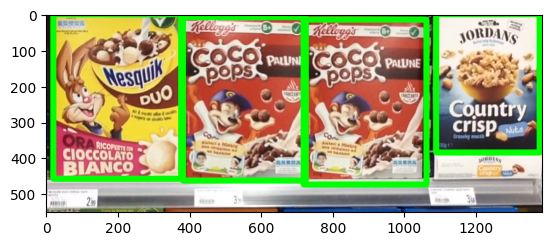

Product Nesquik (Model 0) - 0 instance/s found:
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 0 instance/s found:
Product Country crisp (Model 19) - 1 instance/s found:
	Instance 1 position: (1233, 192), width: 289.0px, height: 385.0px
Product Fitness (Model 24) - 0 instance/s found:
Product CocoPops (Model 25) - 2 instance/s found:
	Instance 1 position: (553, 235), width: 343.0px, height: 455.0px
	Instance 2 position: (890, 244), width: 343.0px, height: 459.0px
Product Nesquik Duo (Model 26) - 1 instance/s found:
	Instance 1 position: (198, 229), width: 357.0px, height: 458.0px
__________________________________________________



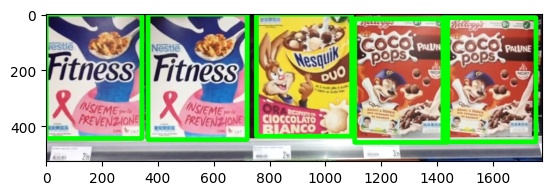

Product Nesquik (Model 0) - 0 instance/s found:
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 0 instance/s found:
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 2 instance/s found:
	Instance 1 position: (171, 222), width: 343.0px, height: 445.0px
	Instance 2 position: (542, 224), width: 355.0px, height: 449.0px
Product CocoPops (Model 25) - 2 instance/s found:
	Instance 1 position: (1271, 238), width: 333.0px, height: 442.0px
	Instance 2 position: (1587, 235), width: 333.0px, height: 444.0px
Product Nesquik Duo (Model 26) - 1 instance/s found:
	Instance 1 position: (923, 218), width: 341.0px, height: 437.0px
__________________________________________________



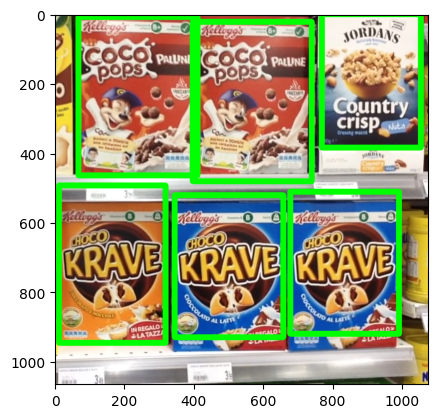

Product Nesquik (Model 0) - 0 instance/s found:
Product CK blue (Model 1) - 2 instance/s found:
	Instance 1 position: (500, 725), width: 313.0px, height: 409.0px
	Instance 2 position: (833, 715), width: 313.0px, height: 409.0px
Product CK orange (Model 11) - 1 instance/s found:
	Instance 1 position: (164, 719), width: 307.0px, height: 453.0px
Product Country crisp (Model 19) - 1 instance/s found:
	Instance 1 position: (910, 192), width: 285.0px, height: 384.0px
Product Fitness (Model 24) - 0 instance/s found:
Product CocoPops (Model 25) - 2 instance/s found:
	Instance 1 position: (238, 236), width: 343.0px, height: 456.0px
	Instance 2 position: (567, 251), width: 343.0px, height: 459.0px
Product Nesquik Duo (Model 26) - 0 instance/s found:
__________________________________________________



In [58]:
# Display images of all models with their corresponding labels
display_model_images(model_features)

for s in scenes:
    plt.imshow(cv2.cvtColor(scenes_bbox[s], cv2.COLOR_BGR2RGB))
    plt.show()
    Output(detections, s)